In [33]:
import numpy as np
from scipy.constants import c, Boltzmann
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy import signal

import pickle
import sympy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed

In [34]:
import os

parent_dir = os.path.dirname(os.getcwd())
print(parent_dir)  # Prints parent directory

os.chdir(parent_dir)
#print(os.getcwd())  # Prints current working directory

import mmars

c:\Users\malth\OneDrive - Aarhus Universitet\Dokumenter\AAU-Studie\10. semester\NEW GIT


In [35]:
radar_model_1 = mmars.FmcwRadar(position=np.array([[0,0]]), signalNoiseRatio=[2000, 10], N_chirps=1)

[[-0.02336045  0.        ]
 [-0.01557363  0.        ]
 [-0.00778682  0.        ]]
[[-0.00292006  0.        ]
 [-0.00097335  0.        ]
 [ 0.00097335  0.        ]
 [ 0.00292006  0.        ]]


## Setting up the target

In [36]:
target_model_1 = mmars.Target(start_position=np.array([[10.001,10.001]]), start_velocity=1., T_total=100., T_frame=0.1)

target_model_1.generate_trajectory(trajectory_type="sinusoidal")

target_ground_truth = target_model_1.get_trajectory()

mrblatcomp = mmars.MRBLaT_Functions(radar_model_1, target_model_1)

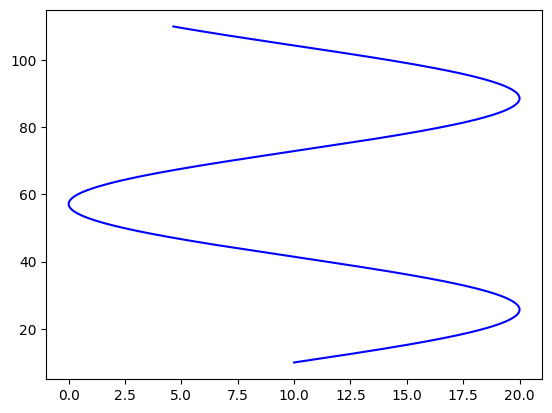

In [37]:
plt.plot(target_ground_truth[0], target_ground_truth[1], label="Ground Truth", color="blue")

In [39]:
simulation_data = mmars.MRBLaT_Functions(radar_model_1, target_model_1)

simulation_data.run()

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000002612735AAF0> and <mmars.target.Target object at 0x00000261273457C0>


100%|██████████| 1000/1000 [00:00<00:00, 1088.20it/s]


In [40]:
sim_data = simulation_data.get_data()

In [41]:
frame = 1

print(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame])

sim_data_all_virtual = sim_data[frame,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

max_range = 100
Ns = 3072


# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

data_fourier_energy = data_fourier.conj().T @ data_fourier

data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

radar_model_1.generate_S_signal(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame])

S_N = radar_model_1.get_S_signal.flatten()[:, np.newaxis]/np.sqrt(256)

10.100998333341666 10.100999999999999


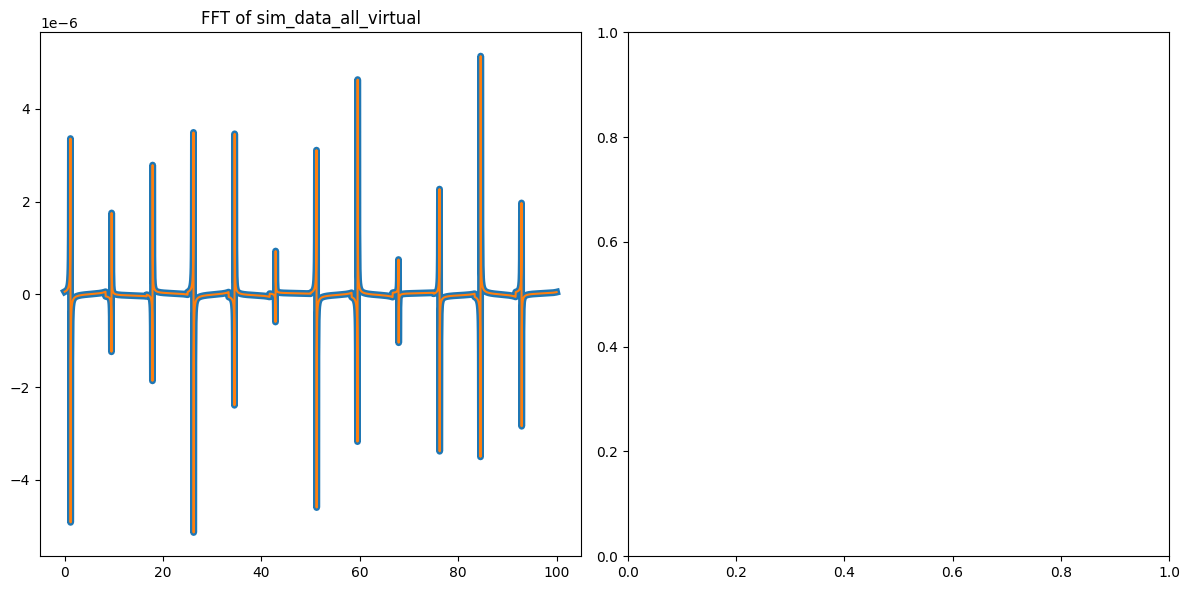

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


#axs[0].plot(np.linspace(0, max_range, Ns), np.abs(data_fourier.T), lw=2)
axs[0].plot(np.linspace(0, max_range, Ns), np.imag(S_N), lw=5)
axs[0].plot(np.linspace(0, max_range, Ns), np.imag(data_fourier))

#axs[0].set_xlim([0, 10])
#axs[0].set_xlim([0, 10])
axs[0].set_title('FFT of sim_data_all_virtual')

#axs[1].set_xlim([0, 10])
#axs[1].set_title('Generated S Signal')

plt.tight_layout()
plt.show()

In [43]:
np.abs(mrblatcomp.alpha_hat(S_N, data_fourier))

array([[1.]])

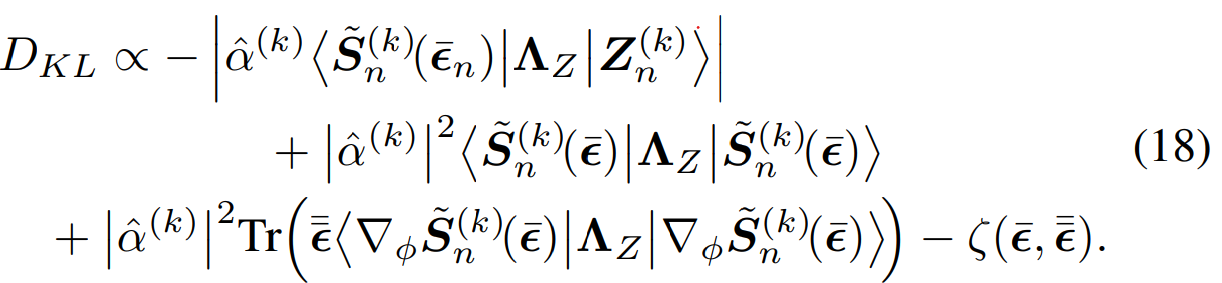

In [44]:
#Lambda_z = np.eye(3072) * (Boltzmann * 290 * 0.77e9)**(-2)
Lambda_z = np.eye(3072) * (radar_model_1.get_standardDeviation)**(-2)
Lambda_z = csr_matrix(Lambda_z)

In [45]:
sim_data_all_virtual = sim_data[frame,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual
data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])
data_fourier_energy = data_fourier.conj().T @ data_fourier
data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

In [46]:
last_frame_x = target_model_1.get_trajectory()[0][frame-1]
last_frame_y = target_model_1.get_trajectory()[1][frame-1]

param = (last_frame_x, last_frame_y, 0.5, 0.5)
bound = [(-100,100), (0.1,100), (0.01, 10), (0.01, 10)]

input = np.array([target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame], 0.5, 0.5])

result = minimize(mrblatcomp.D_KL, param, bounds = bound,  args=(data_fourier, last_frame_x, last_frame_y, (1,1,1,1), True), method='nelder-mead')
#mrblatcomp.D_KL(input, data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1], outputmode=(1,1,1,1), print_output=True)

[[-1.98665221e+202]] [[4.69399654e+202]] [[7.96844534e+201]] 2.1447298858494
[[-4.00894325e+201]] [[4.24747418e+202]] [[7.20214715e+201]] 2.1447298858494
[[1.39700626e+202]] [[4.24747418e+202]] [[7.21015093e+201]] 2.1447298858494
[[-1.98665221e+202]] [[4.69399654e+202]] [[8.13591168e+201]] 2.169124967934116
[[-1.98665221e+202]] [[4.69399654e+202]] [[8.19940127e+201]] 2.169124967934116
[[1.39932574e+202]] [[4.92201212e+202]] [[8.55895574e+201]] 2.1694224984397716
[[-3.85860617e+202]] [[4.41098141e+202]] [[7.53360375e+201]] 2.150960435600036
[[1.68581381e+201]] [[5.02189817e+202]] [[8.77507346e+201]] 2.172466640821
[[-5.06694747e+202]] [[4.43104872e+202]] [[7.5703671e+201]] 2.1517365318749246
[[-4.57839003e+202]] [[4.42192058e+202]] [[7.41612482e+201]] 2.138141333000442
[[-6.36229473e+201]] [[4.2932697e+202]] [[7.13595021e+201]] 2.1231905521753007
[[-4.9029121e+202]] [[4.58958164e+202]] [[7.87354877e+201]] 2.157924429618139
[[4.81326018e+201]] [[4.24623311e+202]] [[7.24890218e+201]] 2.15

In [47]:
print(f"{result.x}\n{target_ground_truth[0][frame], target_ground_truth[1][frame]}")

[1.01119635e+01 1.00928605e+01 1.00000000e-02 1.00000000e-02]
(np.float64(10.100998333341666), np.float64(10.100999999999999))


In [48]:
np.sqrt(result.x[2]), np.sqrt(result.x[3])

(np.float64(0.1), np.float64(0.1))

In [49]:
D_KL_search_space = np.linspace(0.01, 10, 100)

# Use parallel processing to speed up the nested loop
results = []
for i in D_KL_search_space:
    for j in D_KL_search_space:
        result = mmars.mrblatFunctions.D_KL(np.array([11.4, 40, i, j]), data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1], Lambda_z, radar_model_1, mrblatcomp, outputmode=(1,1,1,1), print_output=False)
        results.append(result)

# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

gridsize = 100

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(results).reshape(gridsize, gridsize)
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap, origin='lower', extent=[0, 10, 0, 10], cmap='inferno', aspect='auto')
#min_index = np.argmin(heatmap)
#min_index_2d = np.unravel_index(min_index, heatmap.shape)
#plt.scatter(min_index_2d[1]/gridsize, min_index_2d[0]/gridsize, marker='x', color='red', s=100)
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

AttributeError: module 'mmars.mrblatFunctions' has no attribute 'D_KL'

In [ ]:
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)

print(f"Minimum value at index: {min_index_2d}")

np.min(heatmap)

Minimum value at index: (np.int64(0), np.int64(0))


np.float64(14025.543139649468)

In [ ]:
gridsize = 100

# Define the range for phi[0] and phi[1]
x_values = np.linspace(0.0001, 50.0001, gridsize)  # 0 to 50 (inclusive)
y_values = np.linspace(0.0001, 50.0001, gridsize)

# Create a grid of all combinations of phi[0] and phi[1]

X, Y = np.meshgrid(x_values, y_values)

# Flatten the grid and stack with phi[2] = 0, phi[3] = 0
phis = [np.array([[x], [y], [4.941e-01],  [4.686e-01]]) for x, y in zip(X.ravel(), Y.ravel())]

# Convert to NumPy array (shape: (2500, 4, 1))
phis = np.array(phis)

print(f"Shape of phis: {phis.shape}")  # Expected: (2500, 4, 1)
#print(phis[:-2])  # Print first few vectors

Shape of phis: (10000, 4, 1)


In [ ]:
S_signals = []
for n in tqdm(range(len(phis))):
    S_signals.append(mmars.mrblatFunctions.D_KL(phis[n][:4].flatten(), data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1], Lambda_z, radar_model_1, mrblatcomp, outputmode=(1,1,1,1), print_output=False))

100%|██████████| 10000/10000 [00:18<00:00, 547.84it/s]


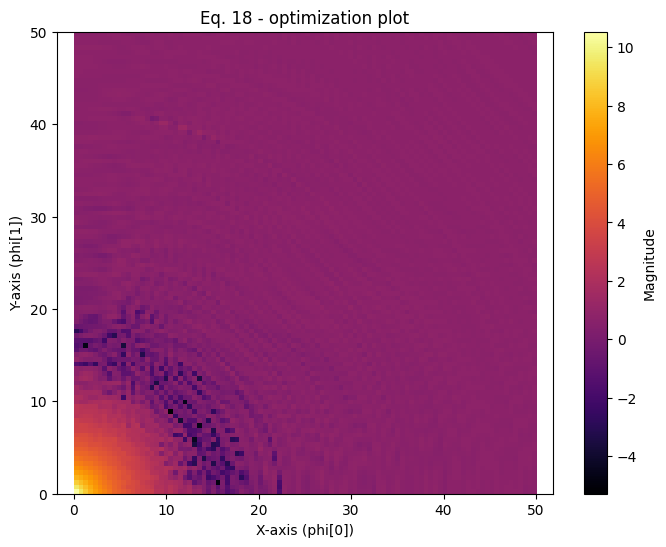

In [ ]:
# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(S_signals).reshape(gridsize, gridsize)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(np.log(np.abs(heatmap[2:,2:])), origin='lower', extent=[0, 50, 0, 50], cmap='inferno')#, aspect='auto')
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

In [ ]:
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)
x_min = x_values[min_index_2d[1]]
y_min = y_values[min_index_2d[0]]

print(f"Minimum value at index: {min_index_2d}")
print(f"x: {x_min}, y: {y_min}")
np.min(heatmap)

Minimum value at index: (np.int64(79), np.int64(25))
x: 12.626362626262626, y: 39.89908989898991


np.float64(-3.9279921162390625)

In [52]:
delta_t = 0.1

T = np.array([[1, 0, delta_t, 0],
            [0, 1, 0, delta_t],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])

mu_a = np.array([[0],
                [0],
                [0],
                [0]])

G = np.diagflat([(delta_t**2)/2,(delta_t**2)/2,delta_t,delta_t])

G_inv = np.linalg.inv(G)

phi = np.array([[10],
                    [10],
                    [0],
                    [0]])

In [53]:
def broadcast_parameters(n, phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_):
    """
    Each radar computes eps_bar and eps_barbar and broadcasts them.
    """
    # FOR LOOP HERE FOR MULTIPLE RADARS
    sim_data_all_virtual = sim_data[n,:,:,0,:].flatten()[:, np.newaxis]
    # Energy normalization
    sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

    data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

    data_fourier_energy = data_fourier.conj().T @ data_fourier

    data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

    result = minimize(mrblatcomp.D_KL, (phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_), bounds = bound,  args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_, (1,1,1,1), False), method='nelder-mead')

    return result.x[np.newaxis].T


def message_passing(N_iter = 100, N = 10):
    eps_bar_list = []
    eps_barbar_list = []

    phi_bar_list = [np.array([[10], [10], [9.9e-1], [1]])]
    phi_barbar_list = [np.array([[0.1,0,0,0], [0,0.1,0,0], [0,0,1e1,0], [0,0,0,1e1]])]

    # Define the shape and rate parameters for the Gamma prior
    zeta = 1
    chi = 1   

    # Number of dimensions
    dim = 4

    # Sample from Gamma distribution
    lambda_diag = np.random.gamma(shape=zeta/2, scale=2/chi, size=dim)

    # Create diagonal matrix
    Lambda_a = np.diag(lambda_diag)
    print(Lambda_a)


    for n in tqdm(range(N)):
        D_KL = broadcast_parameters(n+1, phi_bar_list[n][0, 0], phi_bar_list[n][1, 0], phi_barbar_list[n][0, 0], phi_barbar_list[n][1, 1])
        eps_bar = D_KL[:2]
        eps_bar = np.vstack((eps_bar, np.array([[0.000], [0.000]])))
        eps_bar_list.append(eps_bar)
        eps_barbar_list.append(np.array([[D_KL[2][0],0,0,0], [0,D_KL[3][0],0,0], [0,0,1e1,0], [0,0,0,1e1]]))

        beta = np.zeros((4,4))
        alpha = n+1

        for _ in range(N_iter):
            for i in range(len(phi_bar_list)):
                if i-n == 0:
                    phi_bar_bar_inv = np.linalg.inv(eps_barbar_list[i]) + G_inv.T@Lambda_a@G
                    phi_bar = np.linalg.inv(phi_bar_bar_inv) * np.linalg.inv(eps_barbar_list[i]) @ eps_bar_list[i] + (G_inv.T@Lambda_a@G)@T@phi_bar_list[i]
                else:
                    phi_bar_bar_inv = np.linalg.inv(eps_barbar_list[i]) + G_inv.T@Lambda_a@G + T.T@G_inv.T@Lambda_a@G_inv@T
                    phi_bar = np.linalg.inv(phi_bar_bar_inv) * np.linalg.inv(eps_barbar_list[i]) @ eps_bar_list[i] + (G_inv.T@Lambda_a@G)@T@phi_bar_list[i] + (T.T@G_inv.T@Lambda_a@G_inv@T)@np.linalg.inv(T)@phi_bar_list[i+1]
                    
                if n > 0:
                    beta += np.linalg.norm(np.linalg.inv(G)@(phi_bar-T@phi_bar_list[i]))**2 + G_inv@(np.linalg.inv(phi_bar_bar_inv)+T@phi_barbar_list[i]@T.T)@G_inv.T
        
        if n > 0:
            Lambda_a = np.linalg.inv(beta/alpha)
        
        phi_bar_list.append(phi_bar)
        phi_barbar_list.append(np.linalg.inv(phi_bar_bar_inv))

        
    
    return phi_bar_list, phi_barbar_list

In [54]:
mrblat_data, mrblat_data_phibarbar= message_passing()

[[1.48667695 0.         0.         0.        ]
 [0.         0.32909382 0.         0.        ]
 [0.         0.         0.05094842 0.        ]
 [0.         0.         0.         0.18882434]]


 10%|█         | 1/10 [00:00<00:08,  1.03it/s]C:\Users\malth\AppData\Local\Temp\ipykernel_30328\3272998284.py:16: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(mrblatcomp.D_KL, (phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_), bounds = bound,  args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_, (1,1,1,1), False), method='nelder-mead')
100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


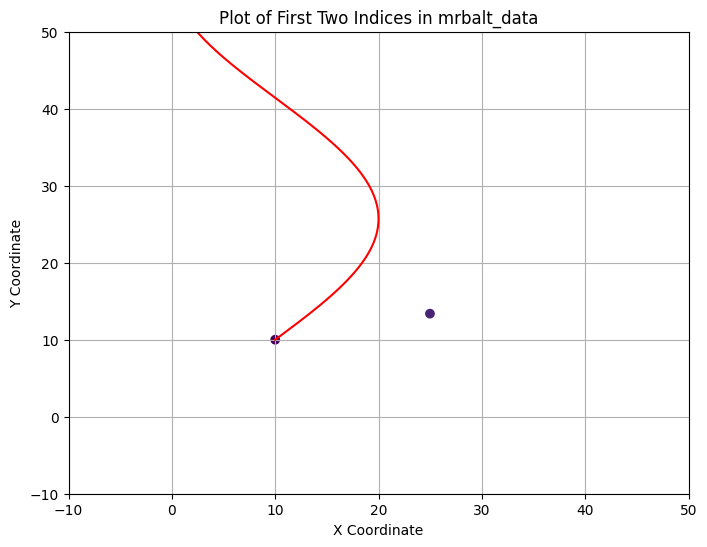

In [56]:
# Extract the first two indices from mrbalt_data
x_coords = [data[0, 0] for data in mrblat_data]
y_coords = [data[1, 0] for data in mrblat_data]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords,c=np.linspace(0, 1, len(x_coords)), cmap='viridis', marker='o')
plt.plot(target_ground_truth[0], target_ground_truth[1], c='red')
plt.xlim([-10, 50])
plt.ylim([-10, 50])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Plot of First Two Indices in mrbalt_data')
plt.grid(True)
plt.show()

In [ ]:
mrblat_data, mrblat_data_phibarbar

([array([[5],
         [5],
         [0],
         [0]]),
  array([[0.5159066 ],
         [0.47098687],
         [0.        ],
         [0.        ]]),
  array([[0.44078891],
         [0.12280644],
         [0.        ],
         [0.        ]]),
  array([[ 4.18609215e+03],
         [-5.20547849e+03],
         [-5.34732763e-10],
         [-1.52649826e-10]]),
  array([[ 4.18550030e+03],
         [-5.20474102e+03],
         [-6.86771019e-10],
         [-6.79159756e-10]]),
  array([[ 4.18550025e+03],
         [-5.20473945e+03],
         [-2.56641263e-13],
         [-2.55099964e-13]]),
  array([[ 4.18550350e+03],
         [-5.20474219e+03],
         [-1.61897719e-15],
         [ 1.48487879e-15]]),
  array([[ 4.18550350e+03],
         [-5.20474218e+03],
         [-3.82648614e-17],
         [ 3.82667758e-17]]),
  array([[ 4.18550350e+03],
         [-5.20474219e+03],
         [-2.78228025e-20],
         [ 2.80030114e-20]]),
  array([[ 4.18550350e+03],
         [-5.20474219e+03],
         [-9.1

In [ ]:
results = np.zeros((50, 4))

results[0] = np.array(([1, 1, 10, 10]))  # Initialize results as a list of lists

for n in tqdm(range(49)):

    sim_data_all_virtual = sim_data[n+1,:,:,0,:]
    sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

    # Energy normalization
    sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

    data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

    data_fourier_energy = data_fourier.conj().T @ data_fourier

    data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T
    
    result = minimize(mmars.mrblatFunctions.D_KL, (results[n][0], results[n][1], results[n][2], results[n][3]), bounds = bound,  args=(data_fourier, results[n][0], results[n][1], Lambda_z, radar_model_1, mrblatcomp, (1,1,1,1), False), method='nelder-mead')


    results[n+1] = result.x.tolist()  # Insert the result at the correct index

100%|██████████| 49/49 [00:29<00:00,  1.65it/s]


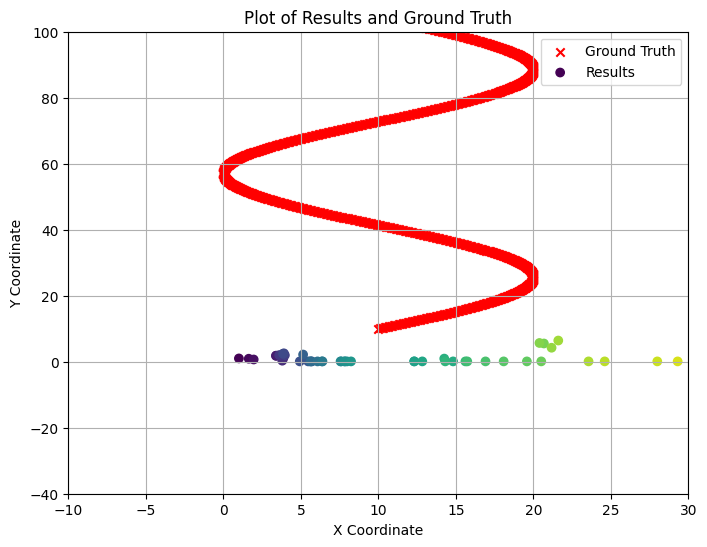

In [ ]:
# Extract the first two indices from results
x_results = [result[0] for result in results]
y_results = [result[1] for result in results]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(target_ground_truth[0], target_ground_truth[1], c='red', marker='x', label='Ground Truth')
plt.scatter(x_results, y_results, c=np.linspace(0, 1, len(x_results)), cmap='viridis', marker='o', label='Results')

#plt.scatter(eq18[0][0], eq18[1][0], c='green', marker='x', label='Eq. 18')
plt.xlim([-10, 30])
plt.ylim([-40, 100])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Plot of Results and Ground Truth')
plt.legend()
plt.grid(True)
plt.show()